In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [28]:
import tensorflow_datasets as tfds
import numpy as np

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data: 
    training_sentences.append(str(s.numpy())) #The values for S and I are tensors, so by calling their NumPy method, I'll actually extract their value.
    training_labels.append(l.numpy())
    
for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())
    
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [29]:
#Hyperparameters
vocab_size = 10000
embedding_dim = 16
max_length =120
trunc_type ="post"
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

#Note that the word index is words that are derived from the training set, so you should expect to see a lot more out of vocabulary tokens in the test set.
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [30]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? b for me this is a story that starts with some funny jokes regarding <OOV> <OOV> when he is travelling with a <OOV> and when he is sitting in business <OOV> the problem is that when you have been watching this movie for an hour you will see the same fantasies funny situations again and again and again it is to predictable it is more done as a tv story where you can go away and come back without missing anything br br i like felix <OOV> as frank but that is not enough even when it is a comedy it has to have more variations and some kind of message to it's audience br br
b"For me this is a story that starts with some funny jokes regarding Franks fanatasies when he is travelling with a staircase and when he is sitting in business meetings... The problem is that when you have been watching this movie for an hour you will see the same fantasies/funny situations again and again and again. It is to predictable. It is more done as a TV story where you can go away and come back without 

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [32]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [38]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))


Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 92us/sample - loss: 0.1275 - accuracy: 0.9644 - val_loss: 0.5741 - val_accuracy: 0.8213
Epoch 2/10
25000/25000 [==============================] - 2s 91us/sample - loss: 0.1170 - accuracy: 0.9685 - val_loss: 0.6299 - val_accuracy: 0.8198
Epoch 3/10
25000/25000 [==============================] - 2s 90us/sample - loss: 0.1065 - accuracy: 0.9731 - val_loss: 0.6775 - val_accuracy: 0.8177
Epoch 4/10
25000/25000 [==============================] - 2s 90us/sample - loss: 0.0976 - accuracy: 0.9773 - val_loss: 0.7314 - val_accuracy: 0.8154
Epoch 5/10
25000/25000 [==============================] - 2s 91us/sample - loss: 0.0894 - accuracy: 0.9796 - val_loss: 0.7666 - val_accuracy: 0.8111
Epoch 6/10
25000/25000 [==============================] - 2s 92us/sample - loss: 0.0828 - accuracy: 0.9814 - val_loss: 0.8312 - val_accuracy: 0.8093
Epoch 7/10
25000/25000 [==============================] 

In [34]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [35]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [36]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [37]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)

[[11], [], [1429], [969], [4], [1537], [1537], [4749], [], [790], [2012], [11], [2920], [2188], [], [790], [2012], [11], [579], [], [11], [579], [], [4], [1783], [4], [4512], [11], [2920], [1277], [], [], [2012], [1003], [2920], [969], [579], [790], []]


# Excercise with the sarcasm dataset

In [88]:
import json
def json_to_dict(file):
    diction= open(file)
    return json.load(diction)

def plain_to_dict(file):
    f= open(file, encoding="utf8")
    return json.load(f)

#Geology
geo1= json_to_dict('geologic_processes.json')
geo2= plain_to_dict('age_of_earth')
#Paleontolgy
paleo= plain_to_dict('paleontology.json')
#Cosmology
cosmo= plain_to_dict('cosmology')
#Ecology
eco= plain_to_dict('ecology_conservation')
#Faith and science
faith= plain_to_dict('faith_and_science')
#Intelligent desgin
design= plain_to_dict('inteligentDesign.json')
#Other sciences


In [132]:
geo= {"geology": list(geo1.values())[0]+list(geo2.values())[0]}
print(geo)

{'geology': [{'title': 'Dinosaurs and Dust', 'author': 'Jim Gibson', 'doc': 'Dinosaur fossils are widespread in Mesozoic sediments, but are absent from the overlying Cenozoic sediments. There is debate over the cause of their extinction. The best-known explanation is that a 10-km  diameter asteroid struck the earth near present-day Mexico’s Yucatan Peninsula at a site called Chicxulub. This impact is calculated to have produced a cloud of dust and gases that blocked the sun and caused a severe cooling that killed the dinosaurs. Another explanation for dinosaur extinction is that extensive volcanism of the Deccan Traps in India generated atmospheric gases that caused climate change and killed the dinosaurs. Extensive volcanism has been linked to the end-Permian and end-Triassic mass extinctions, and is considered a likely contributor to the demise of the dinosaurs in the end-Cretaceous mass-extinction. Previous discussions of these two potential mechanisms have focused on fossil pattern

In [137]:
all_arts= []
all_labels= []

for count,top in enumerate([geo,paleo,cosmo,eco,faith,design]):
    arts= []

    for art in list(top.values())[0][:6]:
        arts.append(art['doc'])
    labels= [count]*len(arts)
    
    all_arts.append(arts)
    all_labels.append(labels)
    print(arts)
    print(labels)


all_arts= [item for sublist in all_arts for item in sublist]
all_labels= [item for sublist in all_labels for item in sublist]

['Dinosaur fossils are widespread in Mesozoic sediments, but are absent from the overlying Cenozoic sediments. There is debate over the cause of their extinction. The best-known explanation is that a 10-km  diameter asteroid struck the earth near present-day Mexico’s Yucatan Peninsula at a site called Chicxulub. This impact is calculated to have produced a cloud of dust and gases that blocked the sun and caused a severe cooling that killed the dinosaurs. Another explanation for dinosaur extinction is that extensive volcanism of the Deccan Traps in India generated atmospheric gases that caused climate change and killed the dinosaurs. Extensive volcanism has been linked to the end-Permian and end-Triassic mass extinctions, and is considered a likely contributor to the demise of the dinosaurs in the end-Cretaceous mass-extinction. Previous discussions of these two potential mechanisms have focused on fossil patterns and event simulations, but have not attempted to model the link between d

In [139]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.33, random_state=42)

In [108]:
#Vocab, index
vocab, index = {}, 1
vocab['<pad>'] = 0 # add a padding token 
for token in tokens:
    if token not in vocab: 
        vocab[token] = index
        index += 1

vocab_size = len(vocab)

inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab)

example_sequence = [vocab[word] for word in tokens]

{0: '<pad>', 1: 'dinosaur', 2: 'fossils', 3: 'are', 4: 'widespread', 5: 'in', 6: 'mesozoic', 7: 'sediments,', 8: 'but', 9: 'absent', 10: 'from', 11: 'the', 12: 'overlying', 13: 'cenozoic', 14: 'sediments.', 15: 'there', 16: 'is', 17: 'debate', 18: 'over', 19: 'cause', 20: 'of', 21: 'their', 22: 'extinction.', 23: 'best-known', 24: 'explanation', 25: 'that', 26: 'a', 27: '10-km', 28: 'diameter', 29: 'asteroid', 30: 'struck', 31: 'earth', 32: 'near', 33: 'present-day', 34: 'mexico’s', 35: 'yucatan', 36: 'peninsula', 37: 'at', 38: 'site', 39: 'called', 40: 'chicxulub.', 41: 'this', 42: 'impact', 43: 'calculated', 44: 'to', 45: 'have', 46: 'produced', 47: 'cloud', 48: 'dust', 49: 'and', 50: 'gases', 51: 'blocked', 52: 'sun', 53: 'caused', 54: 'severe', 55: 'cooling', 56: 'killed', 57: 'dinosaurs.', 58: 'another', 59: 'for', 60: 'extinction', 61: 'extensive', 62: 'volcanism', 63: 'deccan', 64: 'traps', 65: 'india', 66: 'generated', 67: 'atmospheric', 68: 'climate', 69: 'change', 70: 'has', 

In [109]:
#import tensorflow as tf

window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      example_sequence, 
      vocabulary_size=vocab_size,
      window_size=window_size,
      negative_samples=0)

In [110]:
# Get target and context words for one positive skip-gram.
target_word, context_word = positive_skip_grams[0]

# Set the number of negative samples per positive context. 
num_ns = 4

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class, # class that should be sampled as 'positive'
    num_true=1, # each positive skip-gram has 1 positive context class
    num_sampled=num_ns, # number of negative context words to sample
    unique=True, # all the negative samples should be unique
    range_max=vocab_size, # pick index of the samples from [0, vocab_size]
    seed=123, # seed for reproducibility
    name="negative_sampling" # name of this operation
)

In [111]:
# Add a dimension so you can use concatenation (on the next step).
negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

# Concat positive context word with negative sampled words.
context = tf.concat([context_class, negative_sampling_candidates], 0)

# Label first context word as 1 (positive) followed by num_ns 0s (negative).
label = tf.constant([1] + [0]*num_ns, dtype="int64") 

# Reshape target to shape (1,) and context and label to (num_ns+1,).
target = tf.squeeze(target_word)
context = tf.squeeze(context)
label =  tf.squeeze(label)

In [112]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=10)
print(sampling_table)

[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558 ]


In [ ]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [85]:
r= open('other_sciences', encoding="utf8").read()
print(r[17310:17330])
def clean_text(rgx_list, text):
    new_text = text
    for rgx_match in rgx_list:
        new_text = re.sub(rgx_match, '', new_text)
    return new_text


print(clean_text([r'[God\\\'s]'], r))
print(json.load(clean_text([r'[God\\\'s]'], r)))

wledge of God\'s fai
{
    "therScience" : [
        {
            "title" : "OD AND CALCULUS",
            "authr" : "Nrie race Rivera-Pblete",
            "c" : "Calculu i ne f the greatet achievement f the human intellect.  Smetime calle the  mathematic f change, it i the branch f mathematic that eal with the precie way in which change in ne variable relate t change in anther.  In ur aily activitie we encunter tw type f variable:  the that we can cntrl irectly an the that we cannt.  Frtunately, the variable that we cannt cntrl irectly ften repn in me way t the we can.  Fr example, the acceleratin f a car repn t the way in which we cntrl the flw f galine t the engine; the inflatin rate f an ecnmy repn t the way in which the natinal gvernment cntrl the mney upply; an the level f antibitic in a pern bltream repn t the age an timing f a ctr precriptin.  By unertaning quantitatively hw the variable, which we cannt cntrl irectly, repn t the that we can, we can hpe t make preictin abut the

AttributeError: 'str' object has no attribute 'read'

In [20]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Variables
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = "post"
padding_type= "post"
oov_tok = "<OOV>"
training_size = 20000

#Open json
with open ("sarcasm.json", "r") as f:
        datastore = json.load(f)
        
sentences = []
labels = []

for item in datastore:
    sentences.append(item["headline"])
    labels.append(item["is_sarcastic"])

In [21]:
#Training and testing sets
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [22]:
#Tokenize
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

#Padding
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)

#Padding
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                              padding=padding_type, truncating=trunc_type)

In [23]:
#Keras model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [24]:
#Train
num_epochs = 30

history = model.fit(training_padded, training_labels, epochs=num_epochs,
                   validation_data=(testing_padded, testing_labels), verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 2s - loss: 0.5631 - accuracy: 0.6987 - val_loss: 0.3980 - val_accuracy: 0.8290
Epoch 2/30
20000/20000 - 1s - loss: 0.3093 - accuracy: 0.8773 - val_loss: 0.3439 - val_accuracy: 0.8518
Epoch 3/30
20000/20000 - 1s - loss: 0.2313 - accuracy: 0.9099 - val_loss: 0.3473 - val_accuracy: 0.8569
Epoch 4/30
20000/20000 - 1s - loss: 0.1868 - accuracy: 0.9269 - val_loss: 0.3669 - val_accuracy: 0.8517
Epoch 5/30
20000/20000 - 1s - loss: 0.1533 - accuracy: 0.9434 - val_loss: 0.4005 - val_accuracy: 0.8456
Epoch 6/30
20000/20000 - 1s - loss: 0.1296 - accuracy: 0.9543 - val_loss: 0.4363 - val_accuracy: 0.8451
Epoch 7/30
20000/20000 - 1s - loss: 0.1105 - accuracy: 0.9627 - val_loss: 0.4741 - val_accuracy: 0.8425
Epoch 8/30
20000/20000 - 1s - loss: 0.0967 - accuracy: 0.9667 - val_loss: 0.5186 - val_accuracy: 0.8371
Epoch 9/30
20000/20000 - 1s - loss: 0.0824 - accuracy: 0.9725 - val_loss: 0.5733 - val_accuracy: 0.8356
Epoch 10/30
200

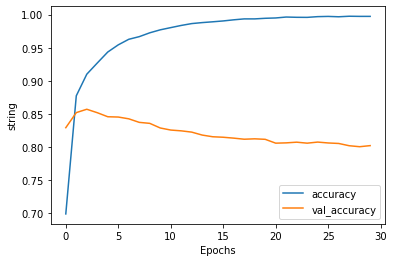

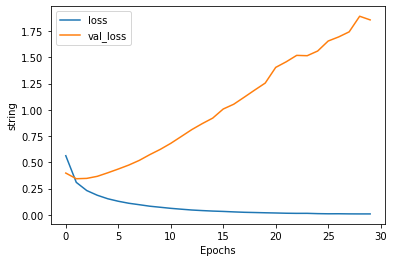

In [26]:
#Plots
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel("string")
    plt.legend([string, "val_"+string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Pre-tokenized datasets

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
imdb,info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [2]:
train_data, test_data = imdb["train"], imdb["test"]

In [3]:
tokenizer = info.features["text"].encoder

In [4]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [5]:
sample_string = "TensorFlow, from basics to mastery"

tokenized_string = tokenizer.encode(sample_string)
print("Tokenized string is {}".format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print("The original string {}:".format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string TensorFlow, from basics to mastery:


In [6]:
for ts in tokenized_string:
    print("{} ------> {}".format(ts, tokenizer.decode([ts])))

6307 ------> Ten
2327 ------> sor
4043 ------> Fl
2120 ------> ow
2 ------> , 
48 ------> from 
4249 ------> basi
4429 ------> cs 
7 ------> to 
2652 ------> master
8050 ------> y


In [7]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [8]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

num_epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_data, epochs=num_epochs, validation_data=test_data)

(8185, 64)
Epoch 1/10
25000/25000 [==============================] - 229s 9ms/step - loss: 5.9605e-08 - accuracy: 0.5020 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
25000/25000 [==============================] - 205s 8ms/step - loss: 5.9607e-08 - accuracy: 0.5020 - val_loss: 5.9605e-08 - val_accuracy: 0.5007
Epoch 3/10
25000/25000 [==============================] - 205s 8ms/step - loss: 5.9607e-08 - accuracy: 0.5020 - val_loss: 5.9605e-08 - val_accuracy: 0.5007
Epoch 4/10
25000/25000 [==============================] - 205s 8ms/step - loss: 5.9607e-08 - accuracy: 0.5020 - val_loss: 5.9605e-08 - val_accuracy: 0.5007
Epoch 5/10
25000/25000 [==============================] - 206s 8ms/step - loss: 5.9607e-08 - accuracy: 0.5020 - val_loss: 5.9605e-08 - val_accuracy: 0.5007
Epoch 6/10
25000/25000 [==============================] - 205s 8ms/step - loss: 5.9607e-08 - accuracy: 0.5020 - val_loss: 5.9605e-08 - val_accuracy: 0.5007
Epoch 7/10
25000/25000 [=========================

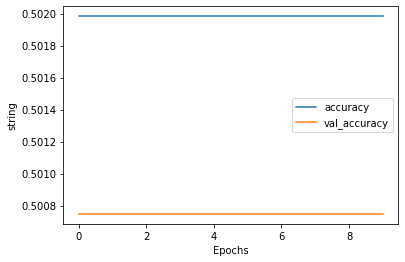

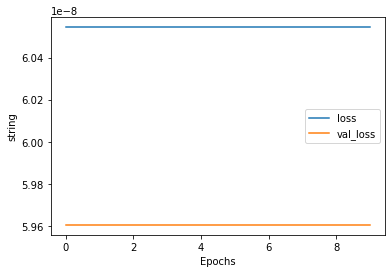

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel("string")
    plt.legend([string, "val_"+string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")